In [1]:
from __future__ import print_function

%matplotlib inline

# basic op
import sys
import numpy as np
import pandas as pd
from collections import Counter
from time import time

# helper util to read data
from chai_deep_net.dna_reader import dna_to_onehot
from chai_deep_net.dna_reader import onehot_to_dna

# deep learning import
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard

# model adjustment
from sklearn.utils import class_weight

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# understand attribution
#from deepexplain.tensorflow import DeepExplain  #not working with TF2.0 yet



Using TensorFlow backend.


In [3]:
tf.__version__

'2.0.0-alpha0'

In [4]:
def basic_dna_model(input_shape):
    X_input = tf.keras.Input(input_shape)
    print(X_input.shape)
    X = tf.keras.layers.Flatten()(X_input)
    X = tf.keras.layers.Dense(6, activation=tf.nn.relu, name='n1')(X)
    X = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, name='n2')(X)  
    model = tf.keras.Model(inputs=X_input, outputs=X, name='basic_dna_model')
    return model

In [5]:
pre_training_data = open('dataset/training_x').read().strip().split('\n')
X_train = np.expand_dims(np.array(map(np.transpose, map(dna_to_onehot, pre_training_data))), axis=4)
Y_train = np.expand_dims(np.array(map(float, open('dataset/training_y').read().strip().split('\n'))), axis=4)

pre_testing_data = open('dataset/test_x').read().strip().split('\n')
X_test = np.expand_dims(np.array(map(np.transpose, map(dna_to_onehot, pre_testing_data))), axis=4)
Y_test = np.expand_dims(np.array(map(float, open('dataset/test_y').read().strip().split('\n'))), axis=4)

print ("number of training examples = " + str(X_train.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))


/Users/chai/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  from ipykernel import kernelapp as app
/Users/chai/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  app.launch_new_instance()
/Users/chai/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


number of training examples = 40000
X_train shape: (40000, 4, 12, 1)
Y_train shape: (40000, 1)
X_test shape: (20168, 4, 12, 1)
Y_test shape: (20168, 1)


/Users/chai/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


In [12]:
input_dimension = X_train.shape[1:]
model = basic_dna_model(input_dimension)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#collect data in TensorBoard
tensorboard = TensorBoard(log_dir="logs/{}".format(time()))

#use weight to address imbalance sample
class_weights = class_weight.compute_class_weight('balanced', np.unique(np.squeeze(Y_train, axis=1)),
                                                  np.squeeze(Y_train, axis=1))
print(class_weights)
class_weights = dict(enumerate(class_weights))

#fit(train) and save stat in history; callbacks = method to customize training which we ask it to use Tansorboard
history = model.fit(X_train, Y_train, epochs=12, batch_size=100, class_weight=class_weights,
                    validation_split=0.2, callbacks=[tensorboard])

(None, 4, 12, 1)
[0.97494394 1.02637791]
Train on 32000 samples, validate on 8000 samples
Epoch 1/12
32000/32000 [==============================] - 1s 23us/sample - loss: 0.6472 - accuracy: 0.6377 - val_loss: 0.6158 - val_accuracy: 0.6855
Epoch 2/12
32000/32000 [==============================] - 1s 19us/sample - loss: 0.6130 - accuracy: 0.6801 - val_loss: 0.5901 - val_accuracy: 0.7031
Epoch 3/12
32000/32000 [==============================] - 1s 16us/sample - loss: 0.5894 - accuracy: 0.6960 - val_loss: 0.5705 - val_accuracy: 0.7166
Epoch 4/12
32000/32000 [==============================] - 1s 16us/sample - loss: 0.5709 - accuracy: 0.7064 - val_loss: 0.5554 - val_accuracy: 0.7245
Epoch 5/12
32000/32000 [==============================] - 0s 15us/sample - loss: 0.5580 - accuracy: 0.7112 - val_loss: 0.5463 - val_accuracy: 0.7228
Epoch 6/12
32000/32000 [==============================] - 0s 15us/sample - loss: 0.5488 - accuracy: 0.7171 - val_loss: 0.5372 - val_accuracy: 0.7261
Epoch 7/12
32000

In [13]:
#use predict to sanitize check imbalance class
y_prob = model.predict(X_test)
rounded = [round(x[0]) for x in y_prob]
print(Counter(np.squeeze(Y_train)))
print(Counter(rounded))

#evaluation
preds = model.evaluate(X_test, Y_test, batch_size=20168, verbose=1, sample_weight=None)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))
#print model summary
model.summary()

# list all data in history
print(history.history.keys())

Counter({0.0: 20514, 1.0: 19486})
Counter({1.0: 11983, 0.0: 8185})
20168/20168 [==============================] - 0s 1us/sample - loss: 0.5289 - accuracy: 0.7180

Loss = 0.5289004445075989
Test Accuracy = 0.71801865
Model: "basic_dna_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 4, 12, 1)]        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 48)                0         
_________________________________________________________________
n1 (Dense)                   (None, 6)                 294       
_________________________________________________________________
n2 (Dense)                   (None, 1)                 7         
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________
['loss', 'val_accuracy', 'val_loss'

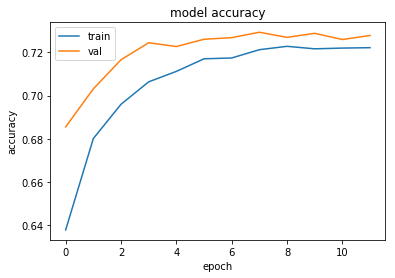

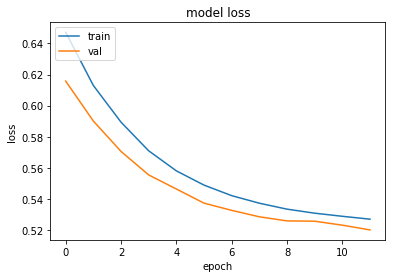

In [14]:
# summarize model performance
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# tensorflow visual
# RUN THIS: tensorboard --logdir=logs
# BROWSE THIS: http://0.0.0.0:6006

The following code does not work with TF2.0 yet due to conflict library which needs session notation. However, we were able to generate some results using Keras with TF1.0 back end.
The idea is to analyze the attribution of dataset. Attribution analysis informs us how each position and value of input affect the model prediction results.
<img src="figure/attribution.png"/>
See https://github.com/Arkarachai/ContextNNN/blob/master/figure/attribution.png for attribution results.


In [ ]:
#https://github.com/marcoancona/DeepExplain
attribution_feature_input=X_test
attribution_response_input=Y_test
with DeepExplain(session=K.get_session()) as de:
    input_tensors = model.layers[0].input
    #input_tensors = model.inputs
    print('input_tensors shape2', type(input_tensors), input_tensors)
    fModel = Model(inputs=input_tensors, outputs=model.outputs)
    target_tensors = fModel(input_tensors)
    xs = attribution_feature_input
    ys = attribution_response_input
    #print('actual input',xs.shape, xs)
    #print('actual output',ys)
    attributions = de.explain('grad*input', target_tensors, input_tensors, xs)
    
sum_attributions=np.sum(attributions,axis=0)
sum_attribution_feature_input=np.sum(attribution_feature_input,axis=0)
#print('sum_attributions',sum_attributions)
#print('sum_attribution_feature_input',sum_attribution_feature_input)
attribution_ratio=sum_attributions/sum_attribution_feature_input
#print('ratio',attribution_ratio)
attribution_ratio=attribution_ratio.squeeze(axis=2)
attribution_ratio=pd.DataFrame(attribution_ratio,index=list('ACGT'),columns=range(1,13))
print(attribution_ratio)

ax = sns.heatmap(attribution_ratio, linewidth=0.5,cmap="YlGnBu")
plt.show()